# Histopathologic Cancer Detection

The purpose of this project is to detect tumors in pathology scans. We are given a large number (~ 220,000) of images for training, and we must predict over a smaller number of images in the holdout test dataset (~ 55,000). Each image is 96 x 96 pixels with 3 channels for RGB colors. The images can be read in using the open-cv library and treated as numpy arrays. There are more negative than positive examples in the training dataset. I will be using a CNN to predict the class label for each image.

In [1]:
#imports
import cv2 as cv
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import seaborn as sns

from keras import layers
#useful variable for some operations below
num_images = 50_000

## EDA

I need to read in the labels for the train dataset and the list of images. Something I missed on my first pass through this project: I needed to properly align my labels with the images I would be using for model training. I chose to do 50k images because it would safely load into memory in this notebook. I made sure the 50k labels matched the 50k images using a pandas join.

In [50]:
#reads in labels and files
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
filepaths = os.listdir('/kaggle/input/histopathologic-cancer-detection/train')
#shortens file list to number of desired images
used_paths = pd.DataFrame(filepaths[:num_images], columns=['filename'])
used_paths.filename = used_paths.filename.str.replace('.tif', '')
#aligns file names with labels
correct_labels = used_paths.set_index('filename').join(labels.set_index('id'), how='left')
train_labels = correct_labels.to_numpy()
correct_labels.head()

,label
filename,
d43c081bafa286f9c1f7e921883f26ceafebc912,1
092d0eedebce504847715ee046b6ad74b57599b4,0
b0d2582c6218a8764323fc940b41312282b99bf4,0
187c99df762f13f99818e5593d4bab4c6577e7e3,1
7c5270c83837de5a5cbb2dca511559dc39d19d53,1


The filenames are aligned with the correct labels. Next, I wanted to clean up my data a bit. One thing I did to relieve some of the memory load was read in the images in grayscale. This reduced the number of channels from 3 to 1, cutting my memory usage by two/thirds. I also scaled my pixel values; this is something I've done before to speed up model training and improve performance. Finally, I needed to expand the dimensions of my images to match the expected input for my models. The extra dimension represents the number of channels (1) for grayscale images.

In [6]:
#defines path to train imgs and np array for imgs
base_path = '/kaggle/input/histopathologic-cancer-detection/train'
images = np.empty((num_images, 96, 96))
#loops through imgs
for i, filepath in enumerate(filepaths[:num_images]):
    if i % 5_000 == 0 and i > 0:
        print(f'{i} images processed.')
    #reads in imgs, scales, adds to array
    image_path = base_path + '/' + filepath
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    scaled = image / 255
    images[i] = scaled
#expand dims for 1 channel (grayscale)    
train_images = np.expand_dims(images, -1)    
print('Finished!')

5000 images processed.
10000 images processed.
15000 images processed.
20000 images processed.
25000 images processed.
30000 images processed.
35000 images processed.
40000 images processed.
45000 images processed.
Finished!


Before we jump into modeling, let's look at the occurrence of the labels in my dataset and take a peek at a couple images!

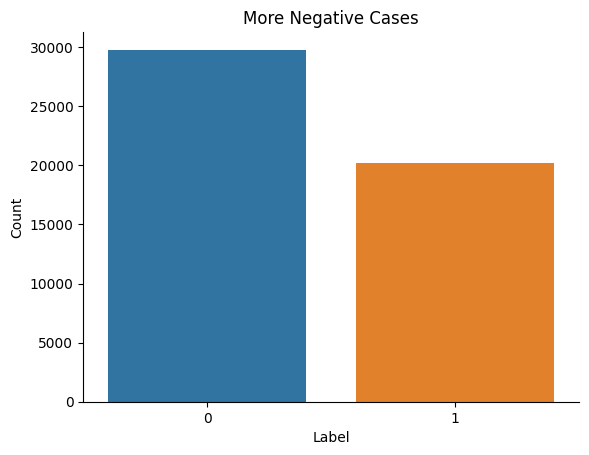

In [4]:
#value counts
label_count = correct_labels.value_counts().reset_index()
sns.barplot(label_count, x='label', y='count')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('More Negative Cases')
sns.despine()

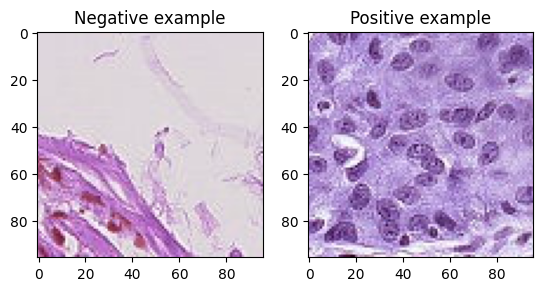

In [12]:
#read in example imgs
pos_path = base_path + '/' + filepaths[0]
neg_path = base_path + '/' + filepaths[1]
pos_img = cv.imread(pos_path)
neg_img = cv.imread(neg_path)
#plot
plt.subplots(1,2)
#negative img
plt.subplot(121)
plt.title('Negative example')
plt.imshow(neg_img)
#positive img
plt.subplot(122)
plt.title('Positive example')
plt.imshow(pos_img)
plt.show()

To my eye, it would be impossible to classify these images! I am unable to tell why one is positive and the other negative. This is why I need to use machine learning with the labeled dataset to solve this problem!

Please note: the baseline accuracy is about 60% for the project. It's the proportion of negative case labels in the dataset.

## Initial model

My initial model architecture is below. My input layer matches the shape of my images: 96 x 96 pixels with 1 channel (because I converted the images to grayscale). I have a couple of 2D convolutional layers followed by a max pooling layer. I used this architecture because it was suggested in one of the lectures. I used leaky relu as my activation function because I read it can have advantages over the regular relu function by allowing small negative values to be passed on to the next layer. My reading suggested this can counteract the vanishing gradients problem. I also included batch normalization after the convolutional layer, something that can help speed up the training process. I decided to include two of these "units" (Conv-Conv-Pool) because I thought one set would be a bit shallow. After these units, I include a flatten layer to turn my 3D object (height, width, channels) into a 1D object to be passed into the dense layers of my network. I have one dense layer to process this input. After that, I have a single neuron in the final layer of my network. It has a single neuron with the sigmoid activation function because I am computing a binary classification. The result of the activation should be the probability the observation belongs to the positive class. I included a couple of dropout layers with minimal dropout to curb any initial overfitting.

In [7]:
#useful variables
img_shape = (96, 96, 1)
kernels = 64
#model architecture
model1 = keras.Sequential([
    layers.Input(shape=img_shape),
    layers.Conv2D(filters=kernels, kernel_size=(3,3), activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels, kernel_size=(3,3), activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=kernels*2, kernel_size=(3,3), activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels*2, kernel_size=(3,3), activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(kernels, activation='leaky_relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid'),
])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 94, 94, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 92, 92, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 92, 92, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 44, 44, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 44, 44, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 42, 42, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 42, 42, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,612,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,873,345 (14.78 MB)

 Trainable params: 3,872,577 (14.77 MB)

 Non-trainable params: 768 (3.00 KB)

Above, you can see the summary of my initial model. Look at the number of parameters for the main dense layer! I'm glad I didn't make it bigger. My model takes in the 96 x 96 images and turns them into 21 x 21 images before passing them off to the dense layer. Let's see if useful information is highlighted by the convolutional layers.

Next, I will train the model. I defined a callback so my model wouldn't train past an unnecessary point. I have a little patience (5 rounds without improved validation accuracy) and then I restore the best weights to the model. This way, whatever model I have should perform the best on the test dataset! My loss is binary crossentropy because this is a binary classification problem. I'm going with the adam optimizer because it was recommended in the lectures. After that, I make sure to pass my callback to the fit method and start training!

In [8]:
#define callback, compile model, and train it!
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history1 = model1.fit(train_images, train_labels, batch_size=128, epochs=100, validation_split=0.2, callbacks=[callback])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 110ms/step - accuracy: 0.7093 - loss: 3.4222 - val_accuracy: 0.4063 - val_loss: 7.3234
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.7459 - loss: 0.7924 - val_accuracy: 0.5619 - val_loss: 1.1032
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.7714 - loss: 0.5495 - val_accuracy: 0.7717 - val_loss: 0.4837
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.7836 - loss: 0.4967 - val_accuracy: 0.7750 - val_loss: 0.5277
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.7992 - loss: 0.4449 - val_accuracy: 0.7336 - val_loss: 0.7140
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.8147 - loss: 0.4227 - val_accuracy: 0.8046 - val_loss: 0.4374
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.8193 - loss: 0.4069 - val_accuracy: 0.7994 - val_loss: 0.4409
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.8286 - loss: 

This initial model performs very well! My training cycle stopped after 18 epochs, identifying epoch 13 as the best iteration of my model. Judging by the train accuracy of 0.8713 and validation accuracy of 0.8301, my model has good performance with minimal overfitting! This model is a great starting point for hyperparameter tuning. I'll share my strategy to tune my model and I'll see if I can improve upon this performance.

Let's take a look at how the accuracy changes over time and the epoch that represents the ideal version of my model.

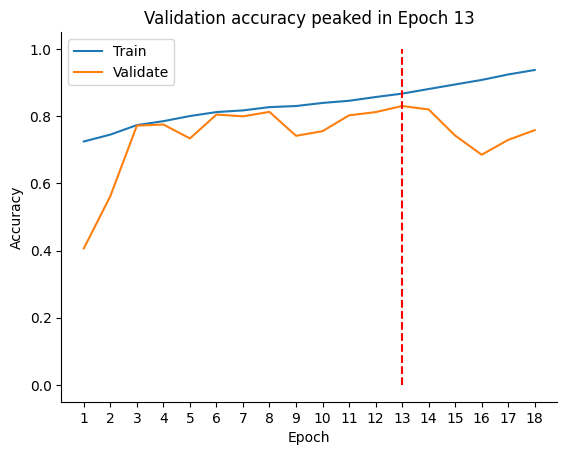

In [47]:
#create dataframe of results; plot them
model_perf = pd.DataFrame({'Train': history1.history['accuracy'], 'Validate': history1.history['val_accuracy']})
plt.plot(range(1, 19), model_perf.Train, label='Train')
plt.plot(range(1, 19), model_perf.Validate, label='Validate')
plt.xticks(list(range(1, 19)))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation accuracy peaked in Epoch 13')
plt.legend()
plt.vlines(13, 0, 1, colors='red', ls='--')
sns.despine()

## Optimization

### Model architecture

My initial results are good (83% accuracy on the validation set). As you can see, after validation accuracy peaks, the model begins to overfit. I would like to improve upon my result by optimizing aspects of my model. I will change my model in the following areas:  
1. **Model architecture (depth)**  
2. Activation function  
3. Size/depth of dense layers  
4. Regularization (dropout)  

I will tinker with model architecture by treating the series of layers (Conv-Conv-Pool) as a unit. My first model had 2 of these units. I will try models with 1 and 3 units. Something to note: I had to redefine my callback each time I trained a new model. Otherwise, it would always stop at the 5th epoch as if it remembered the results from my previous model.

In [9]:
#define smaller model
model2 = keras.Sequential([
    layers.Input(shape=img_shape),
    layers.Conv2D(filters=kernels, kernel_size=(3,3), activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels, kernel_size=(3,3), activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(kernels, activation='leaky_relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid'),
])
#same workflow; define callbacks, compile model, train
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history2 = model2.fit(train_images, train_labels, batch_size=128, epochs=100, validation_split=0.2, callbacks=[callback])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.6665 - loss: 7.3608 - val_accuracy: 0.4862 - val_loss: 25.2517
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.7205 - loss: 2.1980 - val_accuracy: 0.6783 - val_loss: 1.2334
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.7514 - loss: 1.0390 - val_accuracy: 0.7538 - val_loss: 0.6709
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.7778 - loss: 0.6553 - val_accuracy: 0.7626 - val_loss: 0.6521
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.8126 - loss: 0.4577 - val_accuracy: 0.7666 - val_loss: 0.5706
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.8354 - loss: 0.3873 - val_accuracy: 0.6467 - val_loss: 0.9167
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.8465 - loss: 0.3604 - val_accuracy: 0.7470 - val_loss: 0.6340
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.8655 - loss: 

In [10]:
#larger model
model3 = keras.Sequential([
    layers.Input(shape=img_shape),
    layers.Conv2D(filters=kernels, kernel_size=(3,3), activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels, kernel_size=(3,3), activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=kernels*2, kernel_size=(3,3), activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels*2, kernel_size=(3,3), activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=kernels*4, kernel_size=(3,3), activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels*4, kernel_size=(3,3), activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(kernels, activation='leaky_relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid'),
])
#training cycle
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history3 = model3.fit(train_images, train_labels, batch_size=128, epochs=100, validation_split=0.2, callbacks=[callback])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 51s 128ms/step - accuracy: 0.7287 - loss: 1.2446 - val_accuracy: 0.4060 - val_loss: 1.0688
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step - accuracy: 0.7807 - loss: 0.5007 - val_accuracy: 0.6552 - val_loss: 0.7772
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step - accuracy: 0.7846 - loss: 0.4892 - val_accuracy: 0.7535 - val_loss: 0.5710
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step - accuracy: 0.8017 - loss: 0.4426 - val_accuracy: 0.7124 - val_loss: 0.6279
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step - accuracy: 0.8240 - loss: 0.4029 - val_accuracy: 0.6630 - val_loss: 0.6509
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step - accuracy: 0.8408 - loss: 0.3657 - val_accuracy: 0.6019 - val_loss: 3.6469
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step - accuracy: 0.8600 - loss: 0.3355 - val_accuracy: 0.8223 - val_loss: 0.4125
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step - accuracy: 0.8704 -

Let's bundle up the results from the best iterations of the models and see which one performs the best!

In [17]:
#save info to dictionaries
small_train = {'Model': 'Small', 'Subset': 'Train', 'Accuracy': history2.history['accuracy'][4]}
small_val = {'Model': 'Small', 'Subset': 'Validate', 'Accuracy': history2.history['val_accuracy'][4]}

med_train = {'Model': 'Medium', 'Subset': 'Train', 'Accuracy': history1.history['accuracy'][12]}
med_val = {'Model': 'Medium', 'Subset': 'Validate', 'Accuracy': history1.history['val_accuracy'][12]}

large_train = {'Model': 'Large', 'Subset': 'Train', 'Accuracy': history3.history['accuracy'][10]}
large_val = {'Model': 'Large', 'Subset': 'Validate', 'Accuracy': history3.history['val_accuracy'][10]}

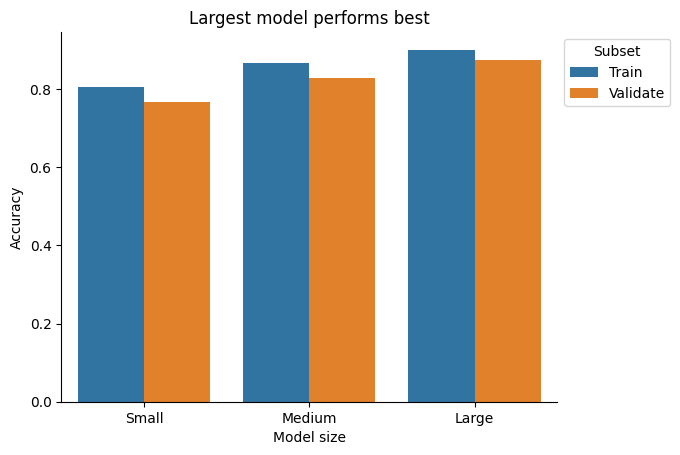

In [24]:
#use dictionaries from previous step to make dataframe; plot
size_comp = pd.DataFrame([small_train, small_val, med_train, med_val, large_train, large_val])
ax = sns.barplot(size_comp, x='Model', y='Accuracy', hue='Subset')
plt.xlabel('Model size')
plt.title('Largest model performs best')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
sns.despine()

It's clear the largest model performs the best. With a small difference (~ 0.025) between the train and validation accuracies, my model performs well on the out-of-sample data portion without overfitting! I will use this model architecture for all future comparisons.

### Activation function

1. Model architecture (depth)  
2. **Activation function**  
3. Size/depth of dense layers  
4. Regularization (dropout)

Now I will try a different activation function! I will train the same model architecture with the relu activation function and compare the results to the one with leaky relu. Below you will see an almost identical model to the large one trained above.

In [1]:
#define model with relu activations
model3a = keras.Sequential([
    layers.Input(shape=img_shape),
    layers.Conv2D(filters=kernels, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=kernels*2, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels*2, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=kernels*4, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels*4, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(kernels, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid'),
])
#train
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)
model3a.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history3a = model3a.fit(train_images, train_labels, batch_size=128, epochs=100, validation_split=0.2, callbacks=[callback])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 141ms/step - accuracy: 0.7435 - loss: 1.0572 - val_accuracy: 0.5506 - val_loss: 0.7409
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - accuracy: 0.7976 - loss: 0.4574 - val_accuracy: 0.5923 - val_loss: 0.8816
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - accuracy: 0.8118 - loss: 0.4308 - val_accuracy: 0.6869 - val_loss: 1.3700
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - accuracy: 0.8247 - loss: 0.4036 - val_accuracy: 0.7737 - val_loss: 0.4866
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - accuracy: 0.8456 - loss: 0.3690 - val_accuracy: 0.7764 - val_loss: 0.4782
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - accuracy: 0.8640 - loss: 0.3345 - val_accuracy: 0.8254 - val_loss: 0.4523
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8755 - loss: 0.3135 - val_accuracy: 0.8550 - val_loss: 0.3533
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8932 - loss: 

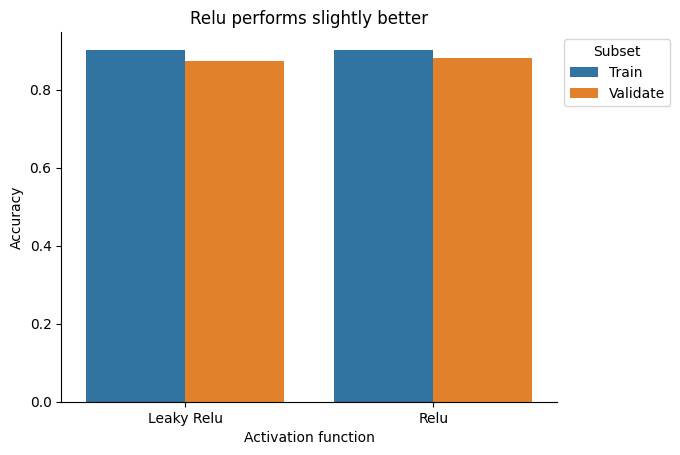

In [5]:
#save info from relu/leaky relu trials; plot
large_train = {'Activation': 'Leaky Relu', 'Subset': 'Train', 'Accuracy': history3.history['accuracy'][10]}
large_val = {'Activation': 'Leaky Relu', 'Subset': 'Validate', 'Accuracy': history3.history['val_accuracy'][10]}
relu_train = {'Activation': 'Relu', 'Subset': 'Train', 'Accuracy': history3a.history['accuracy'][8]}
relu_val = {'Activation': 'Relu', 'Subset': 'Validate', 'Accuracy': history3a.history['val_accuracy'][8]}
act_comp = pd.DataFrame([large_train, large_val, relu_train, relu_val])
ax = sns.barplot(act_comp, x='Activation', y='Accuracy', hue='Subset')
plt.xlabel('Activation function')
plt.title('Relu performs slightly better')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
sns.despine()

After comparing the results, it appears that relu performs slightly better with my model. This could be due to variance (the random initialization of weights within my model) or the activation function could provide an edge. Either way, I'm happy to continue my hyperparameter tuning using relu as my activation function.

### Dense layers

1. Model architecture (depth)  
2. Activation function  
3. **Size/depth of dense layers**  
4. Regularization (dropout)

Moving on to the next stage of optimization: fiddling with my dense layers. I'll try a couple different model architectures. I'll try a larger, single dense layer, and I'll try adding an additional dense layer before the output layer.

In [48]:
#define model with large dense layer (kernels * 4)
model3b = keras.Sequential([
    layers.Input(shape=img_shape),
    layers.Conv2D(filters=kernels, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=kernels*2, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels*2, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=kernels*4, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels*4, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dropout(0.1),
    #large layer here
    layers.Dense(kernels*4, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid'),
])
#training
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)
model3b.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history3b = model3b.fit(train_images, train_labels, batch_size=128, epochs=100, validation_split=0.2, callbacks=[callback])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.7471 - loss: 1.3192 - val_accuracy: 0.5636 - val_loss: 0.6792
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8011 - loss: 0.4413 - val_accuracy: 0.7039 - val_loss: 0.5904
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8213 - loss: 0.4003 - val_accuracy: 0.8165 - val_loss: 0.3999
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8326 - loss: 0.3746 - val_accuracy: 0.8419 - val_loss: 0.3869
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8651 - loss: 0.3237 - val_accuracy: 0.8042 - val_loss: 0.4289
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8814 - loss: 0.2874 - val_accuracy: 0.8375 - val_loss: 0.3758
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8968 - loss: 0.2570 - val_accuracy: 0.7416 - val_loss: 0.7648
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - accuracy: 0.9139 - loss: 

In [49]:
#define model with additional hidden layer
model3d = keras.Sequential([
    layers.Input(shape=img_shape),
    layers.Conv2D(filters=kernels, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=kernels*2, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels*2, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=kernels*4, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels*4, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(kernels*4, activation='relu'),
    layers.Dropout(0.1),
    #additional layer here
    layers.Dense(kernels, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid'),
])
#training
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)
model3d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history3d = model3d.fit(train_images, train_labels, batch_size=128, epochs=100, validation_split=0.2, callbacks=[callback])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.7377 - loss: 1.0388 - val_accuracy: 0.5754 - val_loss: 0.6768
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8032 - loss: 0.4414 - val_accuracy: 0.6923 - val_loss: 0.5635
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8241 - loss: 0.3975 - val_accuracy: 0.8008 - val_loss: 0.4602
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8461 - loss: 0.3590 - val_accuracy: 0.8250 - val_loss: 0.4352
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8643 - loss: 0.3279 - val_accuracy: 0.8479 - val_loss: 0.3889
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8856 - loss: 0.2877 - val_accuracy: 0.7882 - val_loss: 0.6367
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8991 - loss: 0.2542 - val_accuracy: 0.7410 - val_loss: 0.5558
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.9118 - loss:

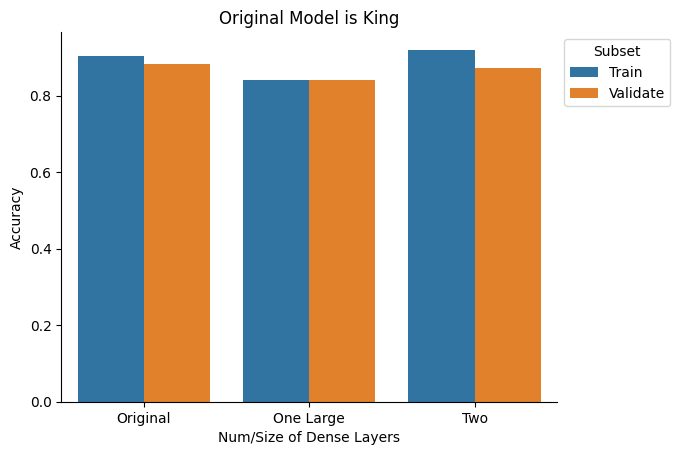

In [52]:
#save info from dense layer trials
ones_train = {'Dense Layers': 'Original', 'Subset': 'Train', 'Accuracy': history3a.history['accuracy'][8]}
ones_val = {'Dense Layers': 'Original', 'Subset': 'Validate', 'Accuracy': history3a.history['val_accuracy'][8]}
onel_train = {'Dense Layers': 'One Large', 'Subset': 'Train', 'Accuracy': history3b.history['accuracy'][3]}
onel_val = {'Dense Layers': 'One Large', 'Subset': 'Validate', 'Accuracy': history3b.history['val_accuracy'][3]}
two_train = {'Dense Layers': 'Two', 'Subset': 'Train', 'Accuracy': history3d.history['accuracy'][8]}
two_val = {'Dense Layers': 'Two', 'Subset': 'Validate', 'Accuracy': history3d.history['val_accuracy'][8]}
#load info into dataframe and plot
act_comp = pd.DataFrame([ones_train, ones_val, onel_train, onel_val, two_train, two_val])
ax = sns.barplot(act_comp, x='Dense Layers', y='Accuracy', hue='Subset')
plt.xlabel('Num/Size of Dense Layers')
plt.title('Original Model is King')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
sns.despine()

My original model with one dense layer (64 neurons) performed the best. Both of the other iterations of the model showed heavy signs of overfitting during the training process. I will take my original model from these trials into the final optimization.

### Dropout

1. Model architecture (depth)  
2. Activation function  
3. Size/depth of dense layers  
4. **Regularization (dropout)**

In my final tuning step, I will tinker with the amount of dropout present surrounding the dense layers. Since my original dropout value is rather low (0.1), I will try no dropout and a dropout of 0.5. Let's see how that changes the results!

In [53]:
#define model with no dropout
model3n = keras.Sequential([
    layers.Input(shape=img_shape),
    layers.Conv2D(filters=kernels, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=kernels*2, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels*2, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=kernels*4, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels*4, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    #no dropout layers surrounding my dense ones
    layers.Dense(kernels, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])
#train
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)
model3n.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history3n = model3n.fit(train_images, train_labels, batch_size=128, epochs=100, validation_split=0.2, callbacks=[callback])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - accuracy: 0.7345 - loss: 0.9378 - val_accuracy: 0.4656 - val_loss: 1.2094
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8018 - loss: 0.4381 - val_accuracy: 0.7209 - val_loss: 0.5307
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8154 - loss: 0.4041 - val_accuracy: 0.7742 - val_loss: 0.5163
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8433 - loss: 0.3589 - val_accuracy: 0.5937 - val_loss: 1.2537
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8614 - loss: 0.3281 - val_accuracy: 0.8363 - val_loss: 0.4442
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8790 - loss: 0.2948 - val_accuracy: 0.8448 - val_loss: 0.3960
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8978 - loss: 0.2557 - val_accuracy: 0.8670 - val_loss: 0.3235
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.9111 - loss: 

In [54]:
#define model with significant dropout
model3s = keras.Sequential([
    layers.Input(shape=img_shape),
    layers.Conv2D(filters=kernels, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=kernels*2, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels*2, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=kernels*4, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=kernels*4, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    #lots of dropout
    layers.Dropout(0.5),
    layers.Dense(kernels, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])
#train
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)
model3s.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history3s = model3s.fit(train_images, train_labels, batch_size=128, epochs=100, validation_split=0.2, callbacks=[callback])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 118ms/step - accuracy: 0.7468 - loss: 0.6251 - val_accuracy: 0.4174 - val_loss: 0.7415
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.7974 - loss: 0.4628 - val_accuracy: 0.7745 - val_loss: 0.4955
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8158 - loss: 0.4230 - val_accuracy: 0.7902 - val_loss: 0.4597
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8304 - loss: 0.3939 - val_accuracy: 0.8054 - val_loss: 0.4065
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8519 - loss: 0.3489 - val_accuracy: 0.7585 - val_loss: 0.5519
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8594 - loss: 0.3329 - val_accuracy: 0.6173 - val_loss: 1.1545
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8740 - loss: 0.3078 - val_accuracy: 0.6277 - val_loss: 1.0350
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8881 - loss: 

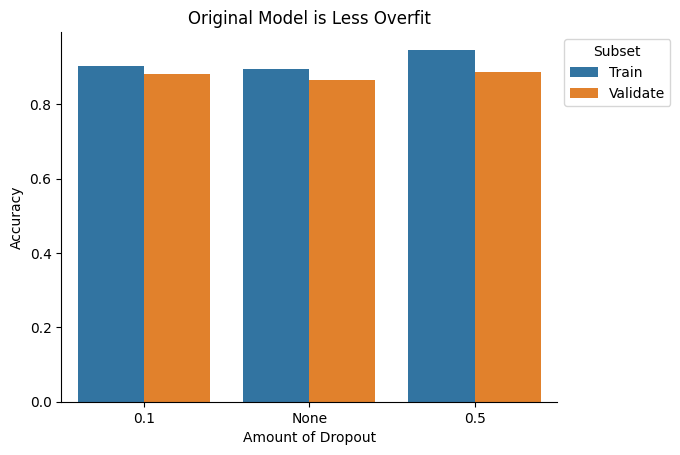

In [17]:
#save values to dictionaries
og_train = {'Dropout': '0.1', 'Subset': 'Train', 'Accuracy': history3a.history['accuracy'][8]}
og_val = {'Dropout': '0.1', 'Subset': 'Validate', 'Accuracy': history3a.history['val_accuracy'][8]}
nd_train = {'Dropout': 'None', 'Subset': 'Train', 'Accuracy': history3n.history['accuracy'][6]}
nd_val = {'Dropout': 'None', 'Subset': 'Validate', 'Accuracy': history3n.history['val_accuracy'][6]}
sd_train = {'Dropout': '0.5', 'Subset': 'Train', 'Accuracy': history3s.history['accuracy'][13]}
sd_val = {'Dropout': '0.5', 'Subset': 'Validate', 'Accuracy': history3s.history['val_accuracy'][13]}
#create dataframe
drop_comp = pd.DataFrame([og_train, og_val, nd_train, nd_val, sd_train, sd_val])
#plot
ax = sns.barplot(drop_comp, x='Dropout', y='Accuracy', hue='Subset')
plt.xlabel('Amount of Dropout')
plt.title('Original Model is Less Overfit')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
sns.despine()

The model without dropout began to show signs of overfitting after a few epochs. The model with significant dropout did slightly outperform the "original" model (with 0.1 dropout layers). The reason why I am carrying my original model forward is because it appears to be less overfit. For the best version of the model with 0.5 dropout layers, the difference between train and validate accuracy is substantial: about 6%. The original model with 0.1 dropout in the layers seems far less overfit.

Now that I have concluded my hyperparameter tuning, I will use my favorite model to make predictions on the holdout test dataset and submit them to the competition!

In [19]:
#create a dataframe of the test files
test_files = os.listdir('/kaggle/input/histopathologic-cancer-detection/test')
submission = pd.DataFrame(test_files, columns=['id'])
submission.id = submission.id.str.replace('.tif', '')
submission = submission.set_index('id')
submission.head()

""
id
a7ea26360815d8492433b14cd8318607bcf99d9e
59d21133c845dff1ebc7a0c7cf40c145ea9e9664
5fde41ce8c6048a5c2f38eca12d6528fa312cdbb
bd953a3b1db1f7041ee95ff482594c4f46c73ed0
523fc2efd7aba53e597ab0f69cc2cbded7a6ce62


In [20]:
#read in and process the test imgs the same way as the train ones
test_num = 57_458
test_path = '/kaggle/input/histopathologic-cancer-detection/test'
t_ims = np.empty((test_num, 96, 96))
for i, test_file in enumerate(test_files):
    if i % 5_000 == 0 and i > 0:
        print(f'{i} images processed.')
    image_path = test_path + '/' + test_file
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    scaled = image / 255
    t_ims[i] = scaled
test_images = np.expand_dims(t_ims, -1)   
print('Finished!')

5000 images processed.
10000 images processed.
15000 images processed.
20000 images processed.
25000 images processed.
30000 images processed.
35000 images processed.
40000 images processed.
45000 images processed.
50000 images processed.
55000 images processed.
Finished!


In [21]:
#create predictions on test subset. i submitted these manually to the competition
preds = model3a.predict(test_images, batch_size=128)
submission['label'] = preds
submission.to_csv('submission.csv')

449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step


My model got a public score of 0.9388 on the test dataset. This project was a great success! Before jumping into the conclusion portion of my notebook, I've included the model summary below.

In [22]:
model3a.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 94, 94, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 92, 92, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 92, 92, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 44, 44, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 44, 44, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 42, 42, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 42, 42, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 19, 19, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 19, 19, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 17, 17, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 17, 17, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,048,640 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,586,053 (25.12 MB)

 Trainable params: 2,194,753 (8.37 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 4,389,508 (16.74 MB)

## Conclusion

In conclusion, I was able to successfully identify cancerous cells in the images! My best model scored 0.9388 on the competition test set, which would have put me in the top 1,000 submissions if the competition was still ongoing! The number one thing I learned from this project: make sure the filepaths and labels are aligned. I wasted too much time because of this oversight on my part. I also learned the importance of experimentation in deep learning projects. Some results surprised me, and my final model looks different from what I expected. Because I did the work and tried different hyperparameters, I think I was able to achieve a better result.

I tried changing different features of my models to get the best result. I tinkered with the depth of the model, the activation functions, the dense layers, and the dropout. I found that increasing the depth of my model helped my predictive power! I think more depth was appropriate for this problem because the images were 96 x 96 pixels. It was ok to have more layers to process this information. In other scenarios with smaller images, a deeper model may be prone to overfitting. Changing activation functions also resulted in a small improvement in my model. I was surprised to find relu outperform leaky relu in my notebook. This isn't conclusive that one is better than the other because of the non-deterministic nature of deep learning models. The weights may have simply been randomized to better values at the beginning of model training. The addition of more dense layers failed to improve my model performance. The model with another dense layer (and more trainable parameters) showed signs of overfitting. Increasing the size of the single dense layer actually worsened performance. The final hyperparameter I tuned was the amount of dropout between layers. My initial models had a small amount of dropout: 0.1 before dense layers. This proved to be the best version of my model. A model with significantly more dropout (0.5 between layers) proved to have slightly better performance on the validate set, however, it showed substantial signs of overfitting. I settled on the final model whose parameters you can see above.

I was fascinated by the more complex architectures described in the lectures. For future improvements, I would like to try adding some of those elements: both skip connections and parallelism. I would also like to try adding more depth to my model because I never found the upper limit where performance began to decrease. I chose not to explore this option because deeper models would mean more computational strain on my resources and longer model training times. I look forward to using this powerful technology more in the future!